<a href="https://colab.research.google.com/github/BCR8/Machine-Metaphors/blob/master/machine_metaphors.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Machine Metaphors
---
Welcome to Machine Metaphors. This particular implementation of the Char-RNN framework was trained on a balanced blend of American English metaphors, idioms, phrases, and jokes to achieve the right balance in producing what the author considers a humorous "mixed metaphor".
Some of the gems produced by this dataset and training parameters include:


## Follow These Steps

This google colab notebook will guide you through some basic steps, allowing you to dive right in with your own dataset and tweak parameters. 
  * Upload our dataset
  * Set some training parameters (you can just use the defaults for now)
  * Define our Model, training loss function, and data input manager and train on a cloud GPU
  * Generate text given a seed phrase
  * Save out model and use it to generate some new text.

This is a Char-RNN implementation in Tensorflow, based on the project from Google's [Seedbank](https://research.google.com/seedbank/seed/charrnn).
Design of the RNN is inspired by [this github project](https://github.com/sherjilozair/char-rnn-tensorflow) which was based on Andrej Karpathy's [char-rnn](https://github.com/karpathy/char-rnn). If you'd like to learn more, Andrej's [blog post](http://karpathy.github.io/2015/05/21/rnn-effectiveness/) is a great place to start.

### Imports and Values Needed to Run this Code

In [0]:
from __future__ import absolute_import, print_function, division
from google.colab import files
from collections import Counter, defaultdict
from copy import deepcopy
from IPython.display import clear_output
from random import randint

import json
import matplotlib.pyplot as plt
import numpy as np
import tensorflow as tf

CHECKPOINT_DIR = './checkpoints/'  #Checkpoints are temporarily kept here.
TEXT_ENCODING = 'utf-8'

### Get the training data.

We can either download the works of Shakespeare to train on or upload our own plain text file that we will be training on.

In [36]:
shakespeare_url = "https://ocw.mit.edu/ans7870/6/6.006/s08/lecturenotes/files/t8.shakespeare.txt"
import urllib
file_contents = urllib.urlopen(shakespeare_url).read()
file_name = "shakespeare"
file_contents = file_contents[10501:]  # Skip headers and start at content
print("An excerpt: \n", file_contents[:664])

An excerpt: 
                      1
  From fairest creatures we desire increase,
  That thereby beauty's rose might never die,
  But as the riper should by time decease,
  His tender heir might bear his memory:
  But thou contracted to thine own bright eyes,
  Feed'st thy light's flame with self-substantial fuel,
  Making a famine where abundance lies,
  Thy self thy foe, to thy sweet self too cruel:
  Thou that art now the world's fresh ornament,
  And only herald to the gaudy spring,
  Within thine own bud buriest thy content,
  And tender churl mak'st waste in niggarding:
    Pity the world, or else this glutton be,
    To eat the world's due, by the grave and thee.


If you want to train on your own training data, run the next two cells. Otherwise skip them.

In [37]:
uploaded = files.upload()

Saving mix_balance.txt to mix_balance.txt


In [38]:
if uploaded:
  if type(uploaded) is not dict: uploaded = uploaded.files  ## Deal with filedit versions
  file_bytes = uploaded[uploaded.keys()[0]]
  utf8_string = file_bytes.decode(TEXT_ENCODING)
  file_contents = utf8_string if files else ''
  file_name = uploaded.keys()[0]
print("An excerpt: \n", file_contents[:664])

An excerpt: 
 I hate how you cant even say black paint anymore Now I have to say "Leroy can you please paint the fence?"
What's the difference between a Jew in Nazi Germany and pizza ? Pizza doesn't scream when you put it in the oven .I'm so sorry.
I recently went to America.... ...and being there really helped me learn about American culture. So I visited a shop and as I was leaving, the Shopkeeper said "Have a nice day!" But I didn't so I sued him.
Brian raises his hand and says, "He's in Heaven." A Sunday school teacher is concerned that his students might be a little confused about Jesus, so he asks his class, "Where is Jesus today?"Brian raises his hand and says


## Set up the recurrent LSTM network 

Before we can do anything, we have to define what our neural network looks like. This next cell creates a class which will contain the tensorflow graph and training parameters that make up the network.

In [0]:
class RNN(object):
  """Represents a Recurrent Neural Network using LSTM cells.

  Attributes:
    num_layers: The integer number of hidden layers in the RNN.
    state_size: The size of the state in each LSTM cell.
    num_classes: Number of output classes. (E.g. 256 for Extended ASCII).
    batch_size: The number of training sequences to process per step.
    sequence_length: The number of chars in a training sequence.
    batch_index: Index within the dataset to start the next batch at.
    on_gpu_sequences: Generates the training inputs for a single batch.
    on_gpu_targets: Generates the training labels for a single batch.
    input_symbol: Placeholder for a single label for use during inference.
    temperature: Used when sampling outputs. A higher temperature will yield
      more variance; a lower one will produce the most likely outputs. Value
      should be between 0 and 1.
    initial_state: The LSTM State Tuple to initialize the network with. This
      will need to be set to the new_state computed by the network each cycle.
    logits: Unnormalized probability distribution for the next predicted
      label, for each timestep in each sequence.
    output_labels: A [batch_size, 1] int32 tensor containing a predicted
      label for each sequence in a batch. Only generated in infer mode.
  """
  def __init__(self,
               rnn_num_layers=1,
               rnn_state_size=128,
               num_classes=256,
               rnn_batch_size=1,
               rnn_sequence_length=1):
    self.num_layers = rnn_num_layers
    self.state_size = rnn_state_size
    self.num_classes = num_classes
    self.batch_size = rnn_batch_size
    self.sequence_length = rnn_sequence_length
    self.batch_shape = (self.batch_size, self.sequence_length)
    print("Built LSTM: ",
          self.num_layers ,self.state_size ,self.num_classes ,
          self.batch_size ,self.sequence_length ,self.batch_shape)


  def build_training_model(self, dropout_rate, data_to_load):
    """Sets up an RNN model for running a training job.

    Args:
      dropout_rate: The rate at which weights may be forgotten during training.
      data_to_load: A numpy array of containing the training data, with each
        element in data_to_load being an integer representing a label. For
        example, for Extended ASCII, values may be 0 through 255.

    Raises:
      ValueError: If mode is data_to_load is None.
    """
    if data_to_load is None:
      raise ValueError('To continue, you must upload training data.')
    inputs = self._set_up_training_inputs(data_to_load)
    self._build_rnn(inputs, dropout_rate)

  def build_inference_model(self):
    """Sets up an RNN model for generating a sequence element by element.
    """
    self.input_symbol = tf.placeholder(shape=[1, 1], dtype=tf.int32)
    self.temperature = tf.placeholder(shape=(), dtype=tf.float32,
                                      name='temperature')
    self.num_options = tf.placeholder(shape=(), dtype=tf.int32,
                                      name='num_options')
    self._build_rnn(self.input_symbol, 0.0)

    self.temperature_modified_logits = tf.squeeze(
        self.logits, 0) / self.temperature

    #for beam search
    self.normalized_probs = tf.nn.softmax(self.logits)

    self.output_labels = tf.multinomial(self.temperature_modified_logits,
                                        self.num_options)

  def _set_up_training_inputs(self, data):
    self.batch_index = tf.placeholder(shape=(), dtype=tf.int32)
    batch_input_length = self.batch_size * self.sequence_length

    input_window = tf.slice(tf.constant(data, dtype=tf.int32),
                            [self.batch_index],
                            [batch_input_length + 1])

    self.on_gpu_sequences = tf.reshape(
        tf.slice(input_window, [0], [batch_input_length]), self.batch_shape)

    self.on_gpu_targets = tf.reshape(
        tf.slice(input_window, [1], [batch_input_length]), self.batch_shape)

    return self.on_gpu_sequences

  def _build_rnn(self, inputs, dropout_rate):
    """Generates an RNN model using the passed functions.

    Args:
      inputs: int32 Tensor with shape [batch_size, sequence_length] containing
        input labels.
      dropout_rate: A floating point value determining the chance that a weight
        is forgotten during evaluation.
    """
    # Alias some commonly used functions
    dropout_wrapper = tf.contrib.rnn.DropoutWrapper
    lstm_cell = tf.contrib.rnn.LSTMCell
    multi_rnn_cell = tf.contrib.rnn.MultiRNNCell

    self._cell = multi_rnn_cell(
        [dropout_wrapper(lstm_cell(self.state_size), 1.0, 1.0 - dropout_rate)
         for _ in range(self.num_layers)])

    self.initial_state = self._cell.zero_state(self.batch_size, tf.float32)

    embedding = tf.get_variable('embedding',
                                [self.num_classes, self.state_size])

    embedding_input = tf.nn.embedding_lookup(embedding, inputs)
    output, self.new_state = tf.nn.dynamic_rnn(self._cell, embedding_input,
                                               initial_state=self.initial_state)

    self.logits = tf.contrib.layers.fully_connected(output, self.num_classes,
                                                    activation_fn=None)


### Let's define our training parameters.
Feel free to leave these untouched at their default values and just run this cell as is. Later, you can come back here and experiment wth these. 
These parameters are just for training. Further down at the inference step, we'll define parameters for the text-generation step.

In [0]:
num_layers = 2
state_size = 256
batch_size = 64
sequence_length = 256
num_training_steps = 30000 # Takes about 40 minuets 
steps_per_epoch = 500
learning_rate = 0.002
learning_rate_decay = 0.95
gradient_clipping = 5.0

###Define your loss function
Loss is a measure of how well the neural network is modeling the data distribution. 

Pass in your logits and the targets you're training against. In this case, target_weights is a set of multipliers that will put higher emphasis on certain outputs. In this notebook, we'll give all outputs equal importance.

In [0]:
def get_loss(logits, targets, target_weights):
  with tf.name_scope('loss'):
    return tf.contrib.seq2seq.sequence_loss(
        logits,
        targets,
        target_weights,
        average_across_timesteps=True)

### Define your optimizer
This tells Tensorflow how to reduce the loss. We will use the popular [ADAM algorithm](https://www.tensorflow.org/api_docs/python/tf/train/AdamOptimizer)

In [0]:
def get_optimizer(loss, initial_learning_rate, gradient_clipping, global_step,
                  decay_steps, decay_rate):

  with tf.name_scope('optimizer'):
    computed_learning_rate = tf.train.exponential_decay(
        initial_learning_rate,
        global_step,
        decay_steps,
        decay_rate,
        staircase=True)

    optimizer = tf.train.AdamOptimizer(computed_learning_rate)
    trained_vars = tf.trainable_variables()
    gradients, _ = tf.clip_by_global_norm(
        tf.gradients(loss, trained_vars),
        gradient_clipping)
    training_op = optimizer.apply_gradients(
        zip(gradients, trained_vars),
        global_step=global_step)

    return training_op, computed_learning_rate

### This class will let us view the progress of our training as it progresses.

In [0]:
class LossPlotter(object):
  def __init__(self, history_length):
    self.global_steps = []
    self.losses = []
    self.averaged_loss_x = []
    self.averaged_loss_y = []
    self.history_length = history_length

  def draw_plots(self):
    self._update_averages(self.global_steps, self.losses,
                          self.averaged_loss_x, self.averaged_loss_y)

    plt.title('Average Loss Over Time')
    plt.xlabel('Global Step')
    plt.ylabel('Loss')
    plt.plot(self.averaged_loss_x, self.averaged_loss_y, label='Loss/Time (Avg)')
    plt.plot()
    plt.plot(self.global_steps, self.losses,
             label='Loss/Time (Last %d)' % self.history_length,
             alpha=.1, color='r')
    plt.plot()
    plt.legend()
    plt.show()

    plt.title('Loss for the last 100 Steps')
    plt.xlabel('Global Step')
    plt.ylabel('Loss')
    plt.plot(self.global_steps, self.losses,
             label='Loss/Time (Last %d)' % self.history_length, color='r')
    plt.plot()
    plt.legend()
    plt.show()

    # The notebook will be slowed down at the end of training if we plot the
    # entire history of raw data. Plot only the last 100 steps of raw data,
    # and the average of each 100 batches. Don't keep unused data.
    self.global_steps = []
    self.losses = []
    self.learning_rates = []

  def log_step(self, global_step, loss):
    self.global_steps.append(global_step)
    self.losses.append(loss)

  def _update_averages(self, x_list, y_list,
                       averaged_data_x, averaged_data_y):
    averaged_data_x.append(x_list[-1])
    averaged_data_y.append(sum(y_list) / self.history_length)

## Now, we're going to start training our model.

This could take a while, so you might want to grab a coffee. Every 30 seconds of training, we're going to save a checkpoint to make sure we don't lose our progress. To monitor the progress of your training, feel free to stop the training every once in a while and run the inference cell to generate text with your model!

First, we will need to turn the plain text file into arrays of tokens (and, later,  back). To do this we will use this token mapper helper class:


In [0]:
import string
class TokenMapper(object):
  def __init__(self):
    self.token_mapping = {}
    self.reverse_token_mapping = {}
  def buildFromData(self, utf8_string, limit=0.00004):
    print("Build token dictionary.")
    total_num = len(utf8_string)
    sorted_tokens = sorted(Counter(utf8_string.decode('utf8')).items(), 
                           key=lambda x: -x[1])
    # Filter tokens: Only allow printable characters (not control chars) and
    # limit to ones that are resonably common, i.e. skip strange esoteric 
    # characters in order to reduce the dictionary size.
    filtered_tokens = filter(lambda t: t[0] in string.printable or 
                             float(t[1])/total_num > limit, sorted_tokens)
    tokens, counts = zip(*filtered_tokens)
    self.token_mapping = dict(zip(tokens, range(len(tokens))))
    for c in string.printable:
      if c not in self.token_mapping:
        print("Skipped token for: ", c)
    self.reverse_token_mapping = {
        val: key for key, val in self.token_mapping.items()}
    print("Created dictionary: %d tokens"%len(self.token_mapping))
  
  def mapchar(self, char):
    if char in self.token_mapping:
      return self.token_mapping[char]
    else:
      return self.token_mapping[' ']
  
  def mapstring(self, utf8_string):
    return [self.mapchar(c) for c in utf8_string]
  
  def maptoken(self, token):
    return self.reverse_token_mapping[token]
  
  def maptokens(self, int_array):
    return ''.join([self.reverse_token_mapping[c] for c in int_array])
  
  def size(self):
    return len(self.token_mapping)
  
  def alphabet(self):
    return ''.join([k for k,v in sorted(self.token_mapping.items(),key=itemgetter(1))])

  def print(self):
    for k,v in sorted(self.token_mapping.items(),key=itemgetter(1)): print(k, v)
  
  def save(self, path):
    with open(path, 'wb') as json_file:
      json.dump(self.token_mapping, json_file)
  
  def restore(self, path):
    with open(path, 'r') as json_file:
      self.token_mapping = {}
      self.token_mapping.update(json.load(json_file))
      self.reverse_token_mapping = {val: key for key, val in self.token_mapping.items()}

Now convert the raw input into a list of tokens.

In [45]:
# Clean the checkpoint directory and make a fresh one
!rm -rf {CHECKPOINT_DIR}
!mkdir {CHECKPOINT_DIR}
!ls -lt

chars_in_batch = (sequence_length * batch_size)
file_len = len(file_contents)
unique_sequential_batches = file_len // chars_in_batch

mapper = TokenMapper()
mapper.buildFromData(file_contents)
mapper.save(''.join([CHECKPOINT_DIR, 'token_mapping.json']))

input_values = mapper.mapstring(file_contents)

total 304
drwxr-xr-x 2 root root   4096 Jan 12 18:48 checkpoints
-rw-r--r-- 1 root root 128457 Jan 12 18:47 mix_balance.txt
-rw-r--r-- 1 root root 170401 Jan 12 18:04 mix_balance_shake.txt
drwxr-xr-x 1 root root   4096 Dec 18 16:52 sample_data
Build token dictionary.
Skipped token for:  +
Skipped token for:  =
Skipped token for:  @
Skipped token for:  \
Skipped token for:  ^
Skipped token for:  {
Skipped token for:  |
Skipped token for:  }
Skipped token for:  ~
Skipped token for:  
Skipped token for:  
Created dictionary: 89 tokens


###First, we'll build our neural network and add our training operations to the Tensorflow graph. 
If you're continuing training after testing your generator, run the next three cells.

In [46]:
tf.reset_default_graph()
config = tf.ConfigProto()
config.gpu_options.allow_growth = True
print('Constructing model...')

model = RNN(
    rnn_num_layers=num_layers,
    rnn_state_size=state_size,
    num_classes=mapper.size(),
    rnn_batch_size=batch_size,
    rnn_sequence_length=sequence_length)

model.build_training_model(0.05, np.asarray(input_values))
print('Constructed model successfully.')

print('Setting up training session...')
neutral_target_weights = tf.constant(
    np.ones(model.batch_shape),
    tf.float32
)
loss = get_loss(model.logits, model.on_gpu_targets, neutral_target_weights)
global_step = tf.get_variable('global_step', shape=(), trainable=False,
                              dtype=tf.int32)
training_step, computed_learning_rate = get_optimizer(
    loss,
    learning_rate,
    gradient_clipping,
    global_step,
    steps_per_epoch,
    learning_rate_decay
)

Constructing model...
Built LSTM:  2 256 89 64 256 (64, 256)
Constructed model successfully.
Setting up training session...


The supervisor will manage the training flow and checkpointing.

In [47]:
# Create a supervisor that will checkpoint the model in the CHECKPOINT_DIR
sv = tf.train.Supervisor(
    logdir=CHECKPOINT_DIR,
    global_step=global_step,
    save_model_secs=30)
print('Training session ready.')

Training session ready.


###This next cell will begin the training cycle. 
First, we will attempt to pick up training where we left off, if a previous checkpoint exists, then continue the training process.

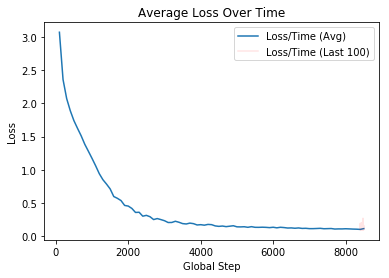

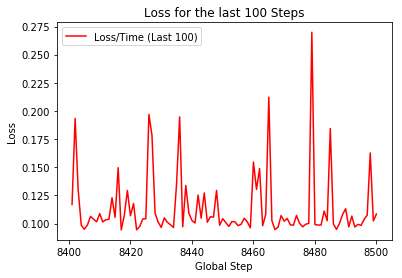

Latest checkpoint is: ./checkpoints/model.ckpt-8496
Learning Rate is: 0.000880
global step 8500, loss=0.108447
global step 8510, loss=0.098636
global step 8520, loss=0.129143
global step 8530, loss=0.102870
global step 8540, loss=0.097835
global step 8550, loss=0.106392


KeyboardInterrupt: ignored

In [48]:
from datetime import datetime
start_time = datetime.now()

with sv.managed_session(config=config) as sess:
  print('Training supervisor successfully initialized all variables.')
  if not file_len:
    raise ValueError('To continue, you must upload training data.')
  elif file_len < chars_in_batch:
    raise ValueError('To continue, you must upload a larger set of data.')

  plotter = LossPlotter(100)
  step_number = sess.run(global_step)
  zero_state = sess.run([model.initial_state])
  max_batch_index = (unique_sequential_batches - 1) * chars_in_batch
  while not sv.should_stop() and step_number < num_training_steps:
    feed_dict = {
        model.batch_index: randint(0, max_batch_index),
        model.initial_state: zero_state
        }
    [_, _, training_loss, step_number, current_learning_rate, _] = sess.run(
        [model.on_gpu_sequences,
         model.on_gpu_targets,
         loss,
         global_step,
         computed_learning_rate,
         training_step],
        feed_dict)
    plotter.log_step(step_number, training_loss)
    if step_number % 100 == 0:
      clear_output(True)
      plotter.draw_plots()
      print('Latest checkpoint is: %s' %
            tf.train.latest_checkpoint(CHECKPOINT_DIR))
      print('Learning Rate is: %f' %
            current_learning_rate)

    if step_number % 10 == 0:
      print('global step %d, loss=%f' % (step_number, training_loss))

clear_output(True)

print('Training completed in HH:MM:SS = ', datetime.now()-start_time)
print('Latest checkpoint is: %s' %
      tf.train.latest_checkpoint(CHECKPOINT_DIR))

## Now, we're going to generate some text!

Here, we'll use the **Beam Search** algorithm to generate some text with our trained model. Beam Search picks N possible next options from each of the current options at every step. This way, if the generator picks an item leading to a bad decision down the line, it can toss the bad result out and keep going with a more likely one.

In [0]:
class BeamSearchCandidate(object):
  """Represents a node within the search space during Beam Search.

  Attributes:
    state: The resulting RNN state after the given sequence has been generated.
    sequence: The sequence of selections leading to this node.
    probability: The probability of the sequence occurring, computed as the sum
      of the probabilty of each character in the sequence at its respective
      step.
  """

  def __init__(self, init_state, sequence, probability):
    self.state = init_state
    self.sequence = sequence
    self.probability = probability

  def search_from(self, tf_sess, rnn_model, temperature, num_options):
    """Expands the num_options most likely next elements in the sequence.

    Args:
      tf_sess: The Tensorflow session containing the rnn_model.
      rnn_model: The RNN to use to generate the next element in the sequence.
      temperature: Modifies the probabilities of each character, placing
        more emphasis on higher probabilities as the value approaches 0.
      num_options: How many potential next options to expand from this one.

    Returns: A list of BeamSearchCandidate objects descended from this node.
    """
    expanded_set = []
    feed = {rnn_model.input_symbol: np.array([[self.sequence[-1]]]),
            rnn_model.initial_state: self.state,
            rnn_model.temperature: temperature,
            rnn_model.num_options: num_options}
    [predictions, probabilities, new_state] = tf_sess.run(
        [rnn_model.output_labels,
         rnn_model.normalized_probs,
         rnn_model.new_state], feed)
    # Get the indices of the num_beams next picks
    picks = [predictions[0][x] for x in range(len(predictions[0]))]
    for new_char in picks:
      new_seq = deepcopy(self.sequence)
      new_seq.append(new_char)
      expanded_set.append(
          BeamSearchCandidate(new_state, new_seq,
                              probabilities[0][0][new_char] + self.probability))
    return expanded_set

  def __eq__(self, other):
    return self.sequence == other.sequence

  def __ne__(self, other):
    return not self.__eq__(other)

  def __hash__(self):
    return hash(self.sequence())

In [0]:
def beam_search_generate_sequence(tf_sess, rnn_model, primer, temperature=0.85,
                                  termination_condition=None, num_beams=5):
  """Implements a sequence generator using Beam Search.

  Args:
    tf_sess: The Tensorflow session containing the rnn_model.
    rnn_model: The RNN to use to generate the next element in the sequence.
    temperature: Controls how 'Creative' the generated sequence is. Values
      close to 0 tend to generate the most likely sequence, while values
      closer to 1 generate more original sequences. Acceptable values are
      within (0, 1].
    termination_condition: A function taking one parameter, a list of
      integers, that returns True when a condition is met that signals to the
      RNN to return what it has generated so far.
    num_beams: The number of possible sequences to keep at each step of the
      generation process.

  Returns: A list of at most num_beams BeamSearchCandidate objects.
  """
  candidates = []

  rnn_current_state = sess.run([rnn_model.initial_state])
  #Initialize the state for the primer
  for primer_val in primer[:-1]:
    feed = {rnn_model.input_symbol: np.array([[primer_val]]),
            rnn_model.initial_state: rnn_current_state
           }
    [rnn_current_state] = tf_sess.run([rnn_model.new_state], feed)

  candidates.append(BeamSearchCandidate(rnn_current_state, primer, num_beams))

  while True not in [termination_condition(x.sequence) for x in candidates]:
    new_candidates = []
    for candidate in candidates:
      expanded_candidates = candidate.search_from(
          tf_sess, rnn_model, temperature, num_beams)
      for new in expanded_candidates:
        if new not in new_candidates:
          #do not reevaluate duplicates
          new_candidates.append(new)
    candidates = sorted(new_candidates,
                        key=lambda x: x.probability, reverse=True)[:num_beams]

  return [c for c in candidates if termination_condition(c.sequence)]

Input something to start your generated text with, and set how characters long you want the text to be.
"Creativity" refers to how much emphasis your neural network puts on matching a pattern. If you notice looping in the output, try raising this value. If your output seems too random, try lowering it a bit.
If the results don't look too great in general, run the three training cells again for a bit longer. The lower your loss, the more closely your generated text will match the training data.

In [51]:
tf.reset_default_graph()
config = tf.ConfigProto()
config.gpu_options.allow_growth = True
sess = tf.InteractiveSession(config=config)

model = RNN(
    rnn_num_layers=num_layers,
    rnn_state_size=state_size,
    num_classes=mapper.size(),
    rnn_batch_size=1,
    rnn_sequence_length=1)

model.build_inference_model()

sess.run(tf.global_variables_initializer())
saver = tf.train.Saver(tf.global_variables())
ckpt = tf.train.latest_checkpoint(CHECKPOINT_DIR)
saver.restore(sess, ckpt)

def gen(start_with, pred, creativity):
  int_array = mapper.mapstring(start_with)
  candidates = beam_search_generate_sequence(
      sess, model, int_array, temperature=creativity,
      termination_condition=pred,
      num_beams=1)
  gentext = mapper.maptokens(candidates[0].sequence)
  return gentext

def lengthlimit(n):
  return lambda text: len(text)>n
def sentences(n):
  return lambda text: mapper.maptokens(text).count(".")>=n
def paragraph():
  return lambda text: mapper.maptokens(text).count("\n")>0



Built LSTM:  2 256 89 1 1 (1, 1)


/usr/local/lib/python2.7/dist-packages/tensorflow_core/python/client/session.py:1750: UserWarning: An interactive session is already active. This can cause out-of-memory errors in some cases. You must explicitly call `InteractiveSession.close()` to release resources held by the other session(s).
  warnings.warn('An interactive session is already active. This can '


In [78]:
length_of_generated_text = 88
creativity = 0.88  # Should be greater than 0 but less than 1

print(gen("Once ", lengthlimit(length_of_generated_text), creativity))

Once says in my life devoted to you. I truly believed that you would protect me through t


## Let's save a copy of our trained RNN so we can do all kinds of cool things with it later.

In [0]:
save_model_to_drive = False  ## Set this to true to save directly to Google Drive.

def save_model_hyperparameters(path):
  with open(path, 'w')  as json_file:
    model_params = {
        'num_layers': model.num_layers,
        'state_size': model.state_size,
        'num_classes': model.num_classes
    }
    json.dump(model_params, json_file)

def save_to_drive(title, content):
  # Install the PyDrive wrapper & import libraries.
  !pip install -U -q PyDrive
  from pydrive.auth import GoogleAuth
  from pydrive.drive import GoogleDrive
  from google.colab import auth
  from oauth2client.client import GoogleCredentials

  # Authenticate and create the PyDrive client.
  auth.authenticate_user()
  gauth = GoogleAuth()
  gauth.credentials = GoogleCredentials.get_application_default()
  drive = GoogleDrive(gauth)

  newfile = drive.CreateFile({'title': title})
  newfile.SetContentFile(content)
  newfile.Upload()
  print('Uploaded file with ID %s as %s'% (newfile.get('id'),
         archive_name))
    
archive_name = ''.join([file_name,'_seedbank_char-rnn.zip'])
latest_model = tf.train.latest_checkpoint(CHECKPOINT_DIR).split('/')[2]
checkpoints_archive_path = ''.join(['./exports/',archive_name])
if not latest_model:
  raise ValueError('You must train a model before you can export one.')
  
%system mkdir exports
%rm -f {checkpoints_archive_path}
mapper.save(''.join([CHECKPOINT_DIR, 'token_mapping.json']))
save_model_hyperparameters(''.join([CHECKPOINT_DIR, 'model_attributes.json']))
%system zip '{checkpoints_archive_path}' -@ '{CHECKPOINT_DIR}checkpoint' \
            '{CHECKPOINT_DIR}token_mapping.json' \
            '{CHECKPOINT_DIR}model_attributes.json' \
            '{CHECKPOINT_DIR}{latest_model}.'*

if save_model_to_drive:
  save_to_drive(archive_name, checkpoints_archive_path)
else:
  files.download(checkpoints_archive_path)



Uploaded file with ID 1dQEv67yQe10ccsW13sJx89ilhCDmXzxP as shakespeare_seedbank_char-rnn.zip
